# Test

Templating demo using test image. templating is used to identify parts of the image that contain moss based on a template.

In [2]:
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

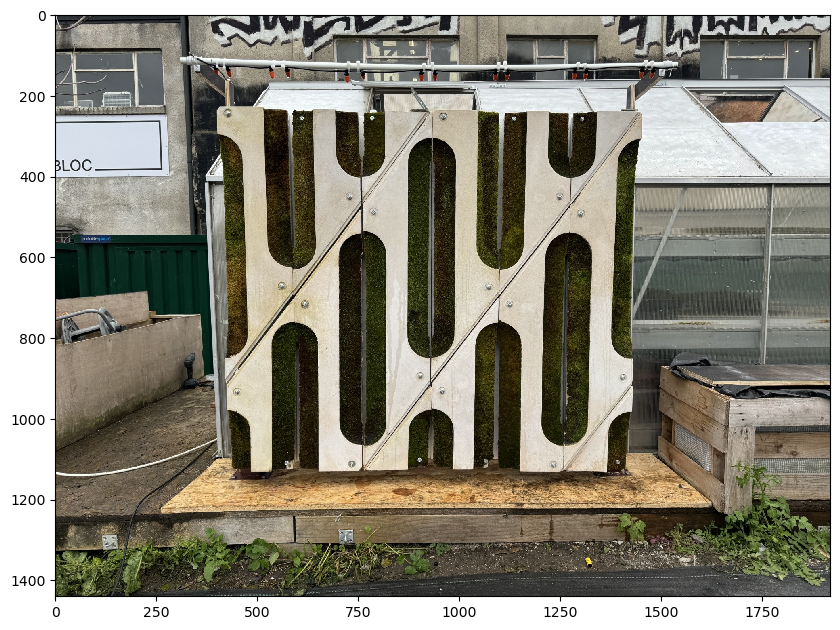

In [3]:
image = cv2.imread("assets/test.jpg")
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), interpolation="nearest")

115.0


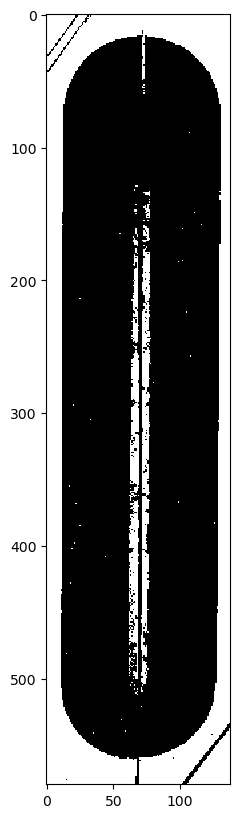

In [4]:
template = image.copy()
template = template[290:870, 862:1000, :]
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
(thresh, template) = cv2.threshold(template, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print(thresh)
h, w = template.shape
plt.figure(figsize=(10, 10))
plt.imshow(template, cmap="gray", interpolation="nearest")

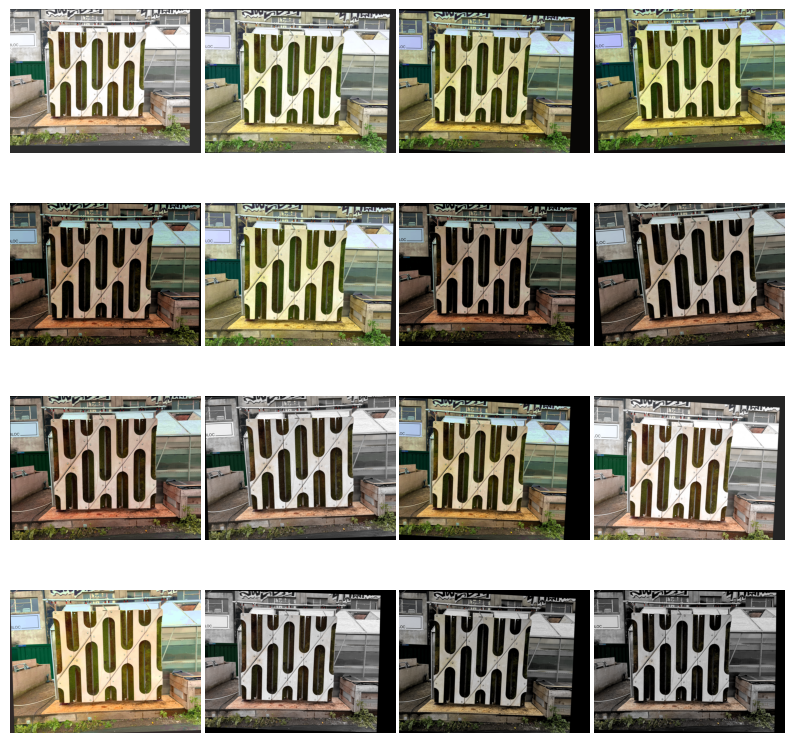

In [10]:
def recolour(image):
    delta_v = random.randint(-50, 50)
    delta_s = random.randint(-50, 50)
    delta_h = random.randint(-10, 10)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = cv2.add(hsv[:, :, 2], delta_v)
    hsv[:, :, 1] = cv2.add(hsv[:, :, 1], delta_s)
    hsv[:, :, 0] = cv2.add(hsv[:, :, 0], delta_h)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img


def wobble(img, ang_range, shear_range, trans_range):
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)

    # Translation
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])
    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
    shear_M = cv2.getAffineTransform(pts1, pts2)
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))

    # Brightness
    img = recolour(img)

    return img


def plot_grid(images, figsize=(10, 10)):
    N = len(images)
    n = int(np.sqrt(N))
    gs1 = gridspec.GridSpec(n, n)
    gs1.update(wspace=0.02, hspace=0.02)  # set the spacing between axes.
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        ax1 = plt.subplot(gs1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect("equal")
        plt.subplot(n, n, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    plt.show()


candidates = [wobble(image.copy(), 2, 2, 2) for _ in range(16)]
plot_grid(candidates, figsize=(10, 10))

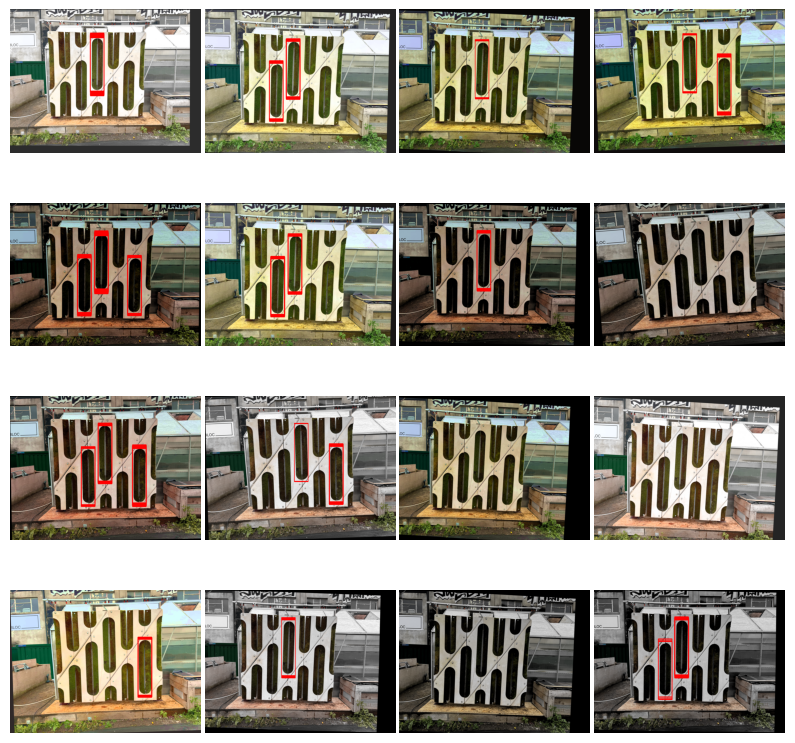

In [12]:
results = []
for img in candidates:
    bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, bw_img) = cv2.threshold(bw_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    res = cv2.matchTemplate(bw_img, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.7
    loc = np.where(res >= threshold)
    _img = img.copy()
    for pt in zip(*loc[::-1]):
        cv2.rectangle(_img, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
    results.append(_img)

plot_grid(results, figsize=(10, 10))

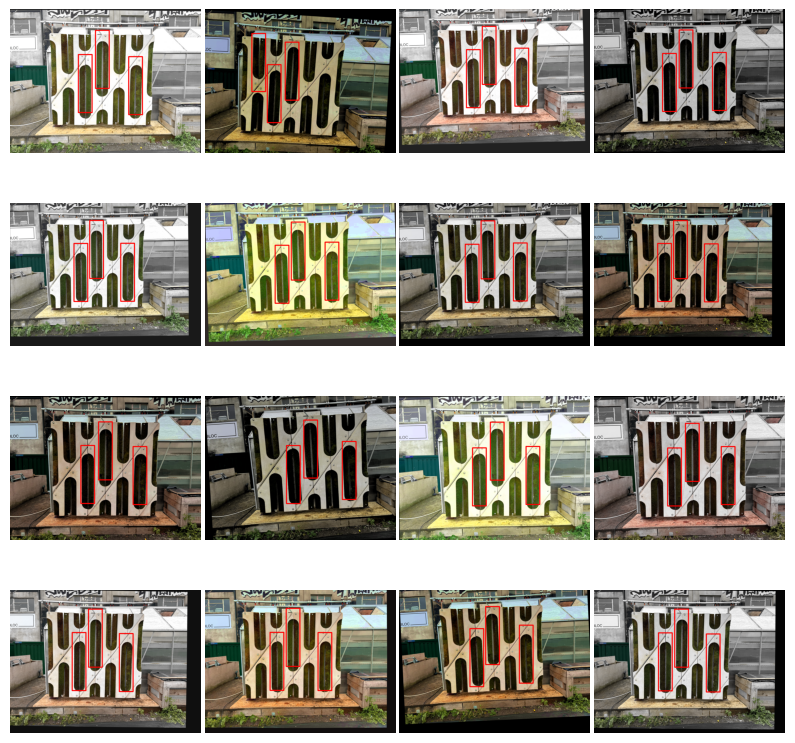

In [34]:
def check_clear(candidates, proposed, w, h):
    for pt in candidates:
        if pt[0] - w < proposed[0] < pt[0] + w and pt[1] - h < proposed[1] < pt[1] + h:
            return False
    return True


results = []
for img in candidates:
    bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, bw_img) = cv2.threshold(bw_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    res = cv2.matchTemplate(bw_img, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.5
    topk = 3
    loc = np.where(res >= threshold)
    h, w = template.shape
    _img = img.copy()
    hits = []
    for pt in zip(*loc[::-1]):
        if check_clear(hits, pt, w, h):
            hits.append(pt)
            cv2.rectangle(_img, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 10)
            if len(hits) == topk:
                break
    results.append(_img)

plot_grid(results, figsize=(10, 10))